<a href="https://colab.research.google.com/github/roshantac/EVA4/blob/master/Step7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, is_L1_loss = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_acc = []
  train_losses = []
   
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(is_L1_loss == True):
      l1_crit = nn.L1Loss(size_average = False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param)*0
        reg_loss +=l1_crit(param,zero_vector)
      factor = 0.0005
      loss += factor * reg_loss
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_losses.append(loss)
  train_acc.append(100*correct/processed)
  return train_losses, train_acc

def test(model, device, test_loader):
    figsize=(15,10)
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = []
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [0]:
def runmodel(Epochs, l1 = False,l2 = 0):
  from torch.optim.lr_scheduler import StepLR
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95,weight_decay = l2 ) # 
  scheduler = StepLR(optimizer, step_size = 6, gamma = 0.1)
  trainLoss = []
  trainAccu = []
  testLoss = []
  testAccu =[]

  EPOCHS = Epochs
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      trainLosst, trainAccut = train(model, device, train_loader, optimizer, epoch, is_L1_loss = l1) 
      trainLoss.append(trainLosst) 
      trainAccu.append(trainAccut)
      testLosst, testAccut = test(model, device, test_loader)
      testLoss.append(testLosst)
      testAccu.append(testAccut)
      scheduler.step()
  return trainLoss, trainAccu, testLoss, testAccu


# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [0]:
trn_ls1,trn_ac1,tst_ls1,tst_ac1 = runmodel(40,l1 = False, l2 = 0) # Normal
trn_ls2,trn_ac2,tst_ls2,tst_ac2 = runmodel(40, l1 = False, l2 = 0.01) # L2
trn_ls3,trn_ac3,tst_ls3,tst_ac3 = runmodel(40, l1 = True, l2 = 0.01) # L1
trn_ls4,trn_ac4,tst_ls4,tst_ac4 = runmodel(40, l1 = True, l2 = 0.01) # L1, L2

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07026080787181854 Batch_id=468 Accuracy=84.50: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9811/10000 (98.11%)

EPOCH: 1


Loss=0.15859737992286682 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.16520853340625763 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9844/10000 (98.44%)

EPOCH: 3


Loss=0.05541849508881569 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.026149356737732887 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.09175476431846619 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.025075504556298256 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.014957785606384277 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.0548740029335022 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 42.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.060593169182538986 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.06897375732660294 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.011471852660179138 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.07752375304698944 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.049570437520742416 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.0053337314166128635 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0333591066300869 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.025753706693649292 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.08370634913444519 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.0024501532316207886 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.04288027808070183 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.023087449371814728 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.01480516791343689 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.05022599175572395 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.014456883072853088 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.03222137317061424 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.041735950857400894 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 42.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.020243674516677856 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 39.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.048638101667165756 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.09916887432336807 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

EPOCH: 29


Loss=0.029129669070243835 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.008847529999911785 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.030446762219071388 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 32


Loss=0.03415585681796074 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.04251004755496979 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)

EPOCH: 34


Loss=0.023283064365386963 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.05691421031951904 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 36


Loss=0.010099932551383972 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 37


Loss=0.10030970722436905 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 38


Loss=0.058561425656080246 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 39


Loss=0.009219050407409668 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 0


Loss=0.12812574207782745 Batch_id=468 Accuracy=86.56: 100%|██████████| 469/469 [00:13<00:00, 43.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1844, Accuracy: 9568/10000 (95.68%)

EPOCH: 1


Loss=0.1475559026002884 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1532, Accuracy: 9642/10000 (96.42%)

EPOCH: 2


Loss=0.11605364084243774 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0851, Accuracy: 9838/10000 (98.38%)

EPOCH: 3


Loss=0.10379163175821304 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1063, Accuracy: 9781/10000 (97.81%)

EPOCH: 4


Loss=0.11484119296073914 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9807/10000 (98.07%)

EPOCH: 5


Loss=0.16812486946582794 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9837/10000 (98.37%)

EPOCH: 6


Loss=0.051391053944826126 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.080372653901577 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.047035712748765945 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.07751383632421494 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.10605540871620178 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.12565644085407257 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.08904395252466202 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.05183476209640503 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.057709891349077225 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.07775074243545532 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.15322968363761902 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.0732373520731926 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.0866408720612526 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.06293965131044388 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.0656123086810112 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.0548667348921299 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 42.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.04648001864552498 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.04395606741309166 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.04627546668052673 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.06301543861627579 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9930/10000 (99.30%)

EPOCH: 26


Loss=0.04288262501358986 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.07111608982086182 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9931/10000 (99.31%)

EPOCH: 28


Loss=0.06682249903678894 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.07950901240110397 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.06022660806775093 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 43.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9929/10000 (99.29%)

EPOCH: 31


Loss=0.03925444558262825 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9929/10000 (99.29%)

EPOCH: 32


Loss=0.07340908795595169 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9928/10000 (99.28%)

EPOCH: 33


Loss=0.06470250338315964 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 37.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9927/10000 (99.27%)

EPOCH: 34


Loss=0.0520247220993042 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.07321681082248688 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9926/10000 (99.26%)

EPOCH: 36


Loss=0.07527227699756622 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9929/10000 (99.29%)

EPOCH: 37


Loss=0.06674003601074219 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9930/10000 (99.30%)

EPOCH: 38


Loss=0.07638388127088547 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9931/10000 (99.31%)

EPOCH: 39


Loss=0.08105171471834183 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9930/10000 (99.30%)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3145611882209778 Batch_id=468 Accuracy=86.81: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2197, Accuracy: 9470/10000 (94.70%)

EPOCH: 1


Loss=0.3340211510658264 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1421, Accuracy: 9678/10000 (96.78%)

EPOCH: 2


Loss=0.31014585494995117 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2021, Accuracy: 9591/10000 (95.91%)

EPOCH: 3


Loss=0.317385196685791 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1302, Accuracy: 9728/10000 (97.28%)

EPOCH: 4


Loss=0.29369300603866577 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1990, Accuracy: 9523/10000 (95.23%)

EPOCH: 5


Loss=0.34384390711784363 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1488, Accuracy: 9676/10000 (96.76%)

EPOCH: 6


Loss=0.1935419738292694 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.2384820282459259 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.22365355491638184 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0769, Accuracy: 9864/10000 (98.64%)

EPOCH: 9


Loss=0.15451578795909882 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9877/10000 (98.77%)

EPOCH: 10


Loss=0.19414111971855164 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9877/10000 (98.77%)

EPOCH: 11


Loss=0.1774088740348816 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.1617044061422348 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 39.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.1403008997440338 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.11670131981372833 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.15622404217720032 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.14988505840301514 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.18466253578662872 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.15709742903709412 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.13451455533504486 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.13352814316749573 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.11152738332748413 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 40.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.15186870098114014 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.1786213368177414 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.15823957324028015 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.12282200157642365 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 40.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9932/10000 (99.32%)

EPOCH: 26


Loss=0.16673186421394348 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 39.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9935/10000 (99.35%)

EPOCH: 27


Loss=0.1578550785779953 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 39.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9933/10000 (99.33%)

EPOCH: 28


Loss=0.12265576422214508 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.1598719209432602 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.12736079096794128 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.13684691488742828 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9931/10000 (99.31%)

EPOCH: 32


Loss=0.12110047042369843 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 40.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.1540399193763733 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9929/10000 (99.29%)

EPOCH: 34


Loss=0.10800477862358093 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.13948236405849457 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9930/10000 (99.30%)

EPOCH: 36


Loss=0.14161688089370728 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9931/10000 (99.31%)

EPOCH: 37


Loss=0.14133065938949585 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9933/10000 (99.33%)

EPOCH: 38


Loss=0.15533995628356934 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9926/10000 (99.26%)

EPOCH: 39


Loss=0.13153374195098877 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9930/10000 (99.30%)

EPOCH: 0


Loss=0.40407609939575195 Batch_id=468 Accuracy=88.26: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1570, Accuracy: 9651/10000 (96.51%)

EPOCH: 1


Loss=0.38847294449806213 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1854, Accuracy: 9572/10000 (95.72%)

EPOCH: 2


Loss=0.23489120602607727 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:14<00:00, 38.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1369, Accuracy: 9711/10000 (97.11%)

EPOCH: 3


Loss=0.29082900285720825 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:14<00:00, 37.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1958, Accuracy: 9541/10000 (95.41%)

EPOCH: 4


Loss=0.24897417426109314 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:14<00:00, 37.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1341, Accuracy: 9748/10000 (97.48%)

EPOCH: 5


Loss=0.25473156571388245 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]


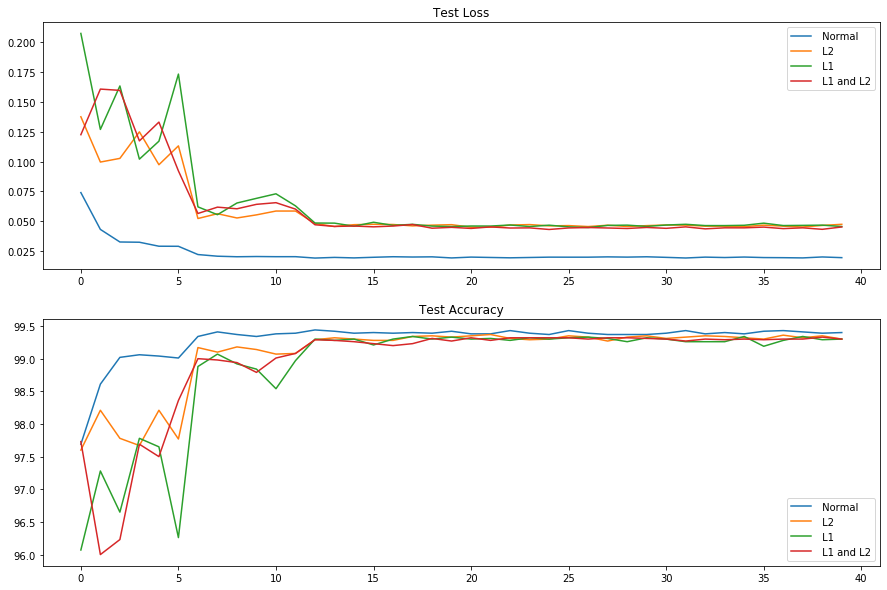

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (axs1,axs2) = plt.subplots(2, 1,figsize=(15,10))

axs1.plot(tst_ls1, label = " Normal")
axs1.plot(tst_ls2, label = " L2")
axs1.plot(tst_ls3, label = " L1")
axs1.plot(tst_ls4, label = " L1 and L2")

axs1.set_title("Test Loss")

axs2.plot(tst_ac1, label = " Normal")
axs2.plot(tst_ac2, label = " L2")
axs2.plot(tst_ac3, label = " L1")
axs2.plot(tst_ac4, label = " L1 and L2")

axs2.set_title("Test Accuracy")
axs1.legend()
axs2.legend()
plt.show()


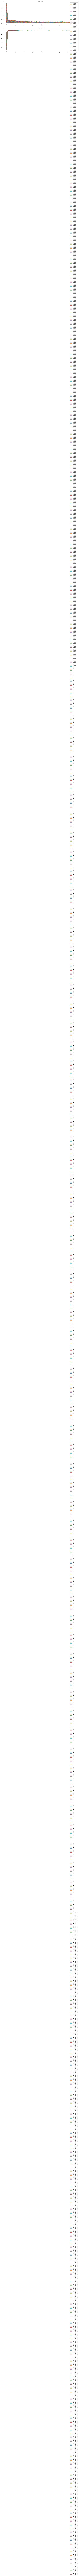

In [14]:
fig1, (axs3,axs4) = plt.subplots(2, 1,figsize=(15,10))

axs3.plot(trn_ls1, label = " Normal")
axs3.plot(trn_ls2, label = " L2")
axs3.plot(trn_ls3, label = " L1")
axs3.plot(trn_ls4, label = " L1 and L2")

axs3.set_title("Train Loss")

axs4.plot(trn_ac1, label = " Normal")
axs4.plot(trn_ac2, label = " L2")
axs4.plot(trn_ac3, label = " L1")
axs4.plot(trn_ac4, label = " L1 and L2")

axs4.set_title("Train Accuracy")
axs3.legend()
axs4.legend()
plt.show()
